# Simple 1D Finite Plasticity model from "Continuum Mechanics of Solids"



In [1]:
import numpy as np

## Some parameters

In [2]:
N = 20 #Steps per quarter cycle
num_quart_cycles = 1 #Number of quarter cycles
strain_rate_sign = np.array([1, -1, -1,1])


e_dot = 0.001 # strain rate per second 
e_max = 0.01 # absolute value of maximum strain


E = 100e9 # Young’s modulus 
Y0 =100e6 # Initial yield 
h0 = 0 # Initial hardening modulus 
Y_star = 300e6 # Yield saturation 
r = 0 #Hardening exponent 
C = 10e9#Backstress modulus 
gamma = 0 # Nonlinear kinematic parameter

T = e_max/e_dot # time per quarter cycle 
dt = T/N  # time step in each increment

e = np.zeros((N*num_quart_cycles+1,1))
ep = np.zeros((N*num_quart_cycles+1,1))
s = np.zeros((N*num_quart_cycles+1,1))
sigma = np.zeros((N*num_quart_cycles+1,1))
q = np.zeros((N*num_quart_cycles+1,1))
Y = np.zeros((N*num_quart_cycles+1,1))



In [3]:
n = 0
Y[0] = Y0

for i in range(num_quart_cycles):
    # Strain increment per time step 
    ii =np.mod(i,4) 
    de = strain_rate_sign[ii] * e_dot * dt
    
    for j in range(N):
        # New total strain at the end of this step 
        e[n+1] = e[n] + de
        
        # Trial stress 
        sigma_trial = sigma[n] + E * de
        xi_trial = sigma_trial - q[n]
        f_trial = np.abs(xi_trial) - Y[n]
        
        if(f_trial < 0): # Elastic step 
            sigma[n+1] = sigma_trial 
            Y[n+1] = Y[n] 
            ep[n+1] = ep[n]
            q[n+1] = q[n]
        else:
            #solve implicit equation for x=abs(dep)
            
            x = de/2
            dx = 100*x #large number
            
            while (np.abs(dx) > 1e-4 *np.abs(x)):
                eta = gamma*x/(1+gamma*x)
                g = abs(xi_trial + eta*q[n]) - (E + (1-eta) *C)*x - (Y[n] + h0*(1-Y[n]/Y_star)**r * x)
                deta_dx = gamma/(1+gamma*x) - gamma*gamma*x/((1+gamma*x)**2)
                dg = np.sign(xi_trial + eta*q[n]) * deta_dx*q[n] - (E + (1-eta)*C) + C*x*deta_dx  - h0*(1-Y[n]/Y_star)**r
                dx = -g/dg
                
                x = x + dx
                
            dep = x
            eta = gamma*x/(1+gamma*x)
            xi_bar_trial = xi_trial + eta*q[n]
            # Update ep(n+1), sigma(n+1), q(n+1)
            ep[n+1] = ep[n] + dep*np.sign(xi_bar_trial)
            sigma[n+1] = E*(e[n+1] - ep[n+1])
            Y[n+1] = Y[n] + h0*(1-Y[n]/Y_star)**r * dep
            q[n+1] = (1-eta) * (q[n] + C*dep*np.sign(xi_bar_trial))
        n=n+1
        

            
                
            
        
    

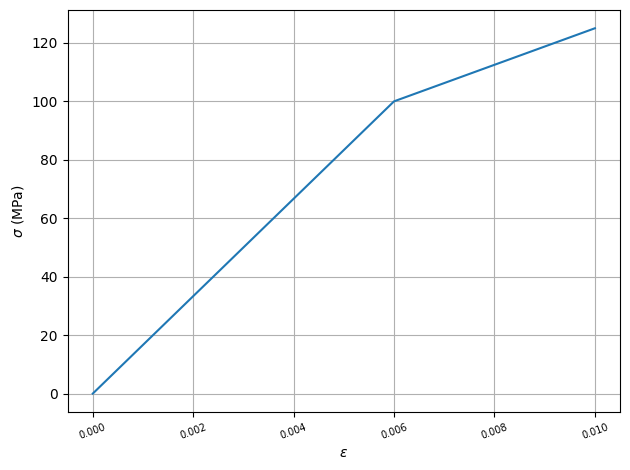

In [4]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(e,sigma/1e6)
plt.xlabel(r"$\epsilon$")
plt.xticks(rotation=20,fontsize=7)
plt.ylabel("$\sigma$ (MPa)")
plt.tight_layout()
plt.grid()

In [5]:
sigma[-1]/1e6

array([125.])